In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc
from petitRADTRANS.physics import guillot_global
import pandas as pd
import time
import os
%matplotlib inline
mpl.rcParams.update({'font.size': 16})

## Analyze Error of Absorption PINN in Detail

- Plot example spectrum and error
- Plot "spectra" of individual species
- Plot (worst-performing) $\alpha$(P)- and transmission-profiles
- Plot respective logarithmic gradient $\frac{\mathrm{d \, log}(\alpha)}{\mathrm{d \, log} (P)}$

This was used to iteratively improve the random generation of the $\alpha$(P)-profiles\
and hence the accuracy of the absorption PINN.

In [2]:
true_transm = pd.read_hdf('../data/test_data_pinns.h5', key='transm')
atm_params = pd.read_hdf('../data/test_data_pinns.h5', key='params')

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
torch.set_num_threads(4)

atmosphere = Radtrans(line_species = ['H2O_HITEMP',
                                      'CO_all_iso_HITEMP',
                                      'CH4',
                                      'CO2',#],
                                      'Na_allard',
                                      'K_allard'],
                      rayleigh_species = ['H2', 'He'],
                      continuum_opacities = ['H2-H2', 'H2-He'],
                      wlen_bords_micron = [0.3, 15],
                      enable_pinn=True)
                      #enable_rayleigh=True)

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
torch.set_num_threads(4)

/home/moon/ddahlb/miniconda3/envs/prt/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:104: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of CH4...
 Done.
  Read line opacities of CO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [4]:
model_file = '../models/HyperparameterSearch/IsothermalAtmoAlt_4x64_100x50_seed=3'
atmosphere.model = torch.load(os.path.join(model_file, 'TrainedModel/model.pkl'), map_location=atmosphere.dev)

In [5]:
pressures = np.logspace(-6, 2, 100)

In [6]:
atmosphere.setup_opa_structure(pressures)

In [7]:
R_pl = 1.838*nc.r_jup_mean
gravity = 1e1**2.8
P0 = 0.01

kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.
# temperature = guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

temperature = 1200. * np.ones_like(pressures)

MMWs = {}
MMWs['H2'] = 2 * 1.008
MMWs['He'] = 4.0026
MMWs['H2O_HITEMP'] = 2 * 1.008 + 15.999
MMWs['CO_all_iso_HITEMP'] = 12.011 + 15.999
MMWs['CO2'] = 12.011 + 2 * 15.999
MMWs['CH4'] = 12.011 + 4 * 1.008
MMWs['Na_allard'] = 22.99
MMWs['K_allard'] = 39.098

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
mass_fractions['He'] = 0.24 * np.ones_like(temperature)
mass_fractions['H2O_HITEMP'] = 0.001 * np.ones_like(temperature)
mass_fractions['CO_all_iso_HITEMP'] = 0.01 * np.ones_like(temperature)
mass_fractions['CO2'] = 0.00001 * np.ones_like(temperature)
mass_fractions['CH4'] = 0.000001 * np.ones_like(temperature)
mass_fractions['Na_allard'] = 0.00001 * np.ones_like(temperature) # default: 0.00001
mass_fractions['K_allard'] = 0.000001 * np.ones_like(temperature) # default: 0.000001

MMW = 2.33 * np.ones_like(temperature)

genAlpha = False
if genAlpha:
    msa = torch.tensor(np.array([np.linspace(-18.0,-6.0,100), np.linspace(6/2,10/2,100)]).swapaxes(0,1))
    std_rad = (np.sqrt(49.5**2 - (np.arange(100)-49.5)**2) / 49.5 * 0.05)
    std_rad[0] = 1.0
    std_rad[-1] = 1.0
    msr = torch.tensor(np.array([np.linspace(1.0,-1.0,100),std_rad]).swapaxes(0,1))
    print(msa.shape, msr.shape)
    atmosphere.mean_std_alpha = msa
    atmosphere.mean_std_radii = msr
# atmosphere.mean_std_alpha = torch.cat([torch.linspace(-18.0, -6.0, 100, dtype=torch.float32).unsqueeze(1), torch.linspace(4.5, 4.5, 100, dtype=torch.float32).unsqueeze(1)], dim=1).to(atmosphere.dev)

# cloud stuff
# kappa_zero = 0.01
# gamma_scat = -4.

def get_details(atm_params):
    
    R_pl = atm_params['R_pl']*nc.r_jup_mean
    log_g = atm_params['log(g)'] # (SI units)
    gravity = 10**log_g * 100.0 # (SI to cgs!)
    P0 = 0.01 # pressure at R_pl

    temperature = atm_params['T'] * np.ones_like(pressures)

    vol_fractions = {}
    vol_fractions['H2O_HITEMP'] = (10.0**atm_params['log(H2O)'])
    vol_fractions['CO_all_iso_HITEMP'] = (10.0**atm_params['log(CO)'])
    vol_fractions['CO2'] = (10.0**atm_params['log(CO2)'])
    vol_fractions['CH4'] = (10.0**atm_params['log(CH4)'])

    rest_vol = 1.0
    for vol_frac in vol_fractions.values():
        rest_vol -=  vol_frac
    
    vol_fractions['He'] = rest_vol * atm_params['He/H2']
    vol_fractions['H2'] = rest_vol * (1.0 - atm_params['He/H2'])

    MMW = 0.0 * np.ones_like(pressures)
    for name, frac in vol_fractions.items():
        MMW += frac * MMWs[name]

    mass_fractions = {}
    for name, frac in vol_fractions.items():
        mass_fractions[name] = frac * MMWs[name] / MMW

    mass_fractions['Na_allard'] = 0.0
    mass_fractions['K_allard'] = 0.0
    
    # calculate transmission spectrum
    atmosphere.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0)

    return atmosphere.transmission, atmosphere.alphas, atmosphere.radius_hse

def calc_MMW(atm_params):

    vol_fractions = {}
    vol_fractions['H2O_HITEMP'] = (10.0**atm_params['log(H2O)'])
    vol_fractions['CO_all_iso_HITEMP'] = (10.0**atm_params['log(CO)'])
    vol_fractions['CO2'] = (10.0**atm_params['log(CO2)'])
    vol_fractions['CH4'] = (10.0**atm_params['log(CH4)'])

    rest_vol = 1.0
    for vol_frac in vol_fractions.values():
        rest_vol -=  vol_frac
    
    vol_fractions['He'] = rest_vol * atm_params['He/H2']
    vol_fractions['H2'] = rest_vol * (1.0 - atm_params['He/H2'])

    MMW = 0.0 * np.ones_like(pressures)
    for name, frac in vol_fractions.items():
        MMW += frac * MMWs[name]

    return MMW

In [8]:
#ind = 21
extra_spec = False
atmosphere.batch_size = int(2**24)

if extra_spec:
    atmosphere.enable_pinn = False
    atmosphere.enable_rayleigh = True
    atmosphere.rayleigh_on = 1
    start = time.time()
    # pinn_transm, alphas, radius_hse = get_details(atm_params.iloc[ind])
    atmosphere.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0)
    end = time.time()
    print(end-start)
    rayleigh_transm = atmosphere.transmission
    rayleigh_transm_rad = atmosphere.transm_rad
    
    atmosphere.enable_pinn = False
    atmosphere.enable_rayleigh = True
    atmosphere.rayleigh_on = 0
    start = time.time()
    # pinn_transm, alphas, radius_hse = get_details(atm_params.iloc[ind])
    atmosphere.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0)
    end = time.time()
    print(end-start)
    rayleigh_abs_transm = atmosphere.transmission
    rayleigh_abs_transm_rad = atmosphere.transm_rad

atmosphere.enable_pinn = True
atmosphere.enable_rayleigh = False
#atmosphere.rayleigh_on = 1
start = time.time()
# pinn_transm, alphas, radius_hse = get_details(atm_params.iloc[ind])
atmosphere.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0)
end = time.time()
print(end-start)
pinn_transm = atmosphere.transmission
pinn_transm_rad = atmosphere.transm_rad

atmosphere.enable_pinn = False
atmosphere.enable_rayleigh = False
start = time.time()
# prt_transm, alphas, radius_hse = get_details(atm_params.iloc[ind])
atmosphere.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0)
end = time.time()
print(end-start)
prt_transm, alphas, radius_hse = atmosphere.transmission, atmosphere.alphas, atmosphere.radius_hse
prt_transm_rad = atmosphere.transm_rad

23.074723958969116
2.1072866916656494


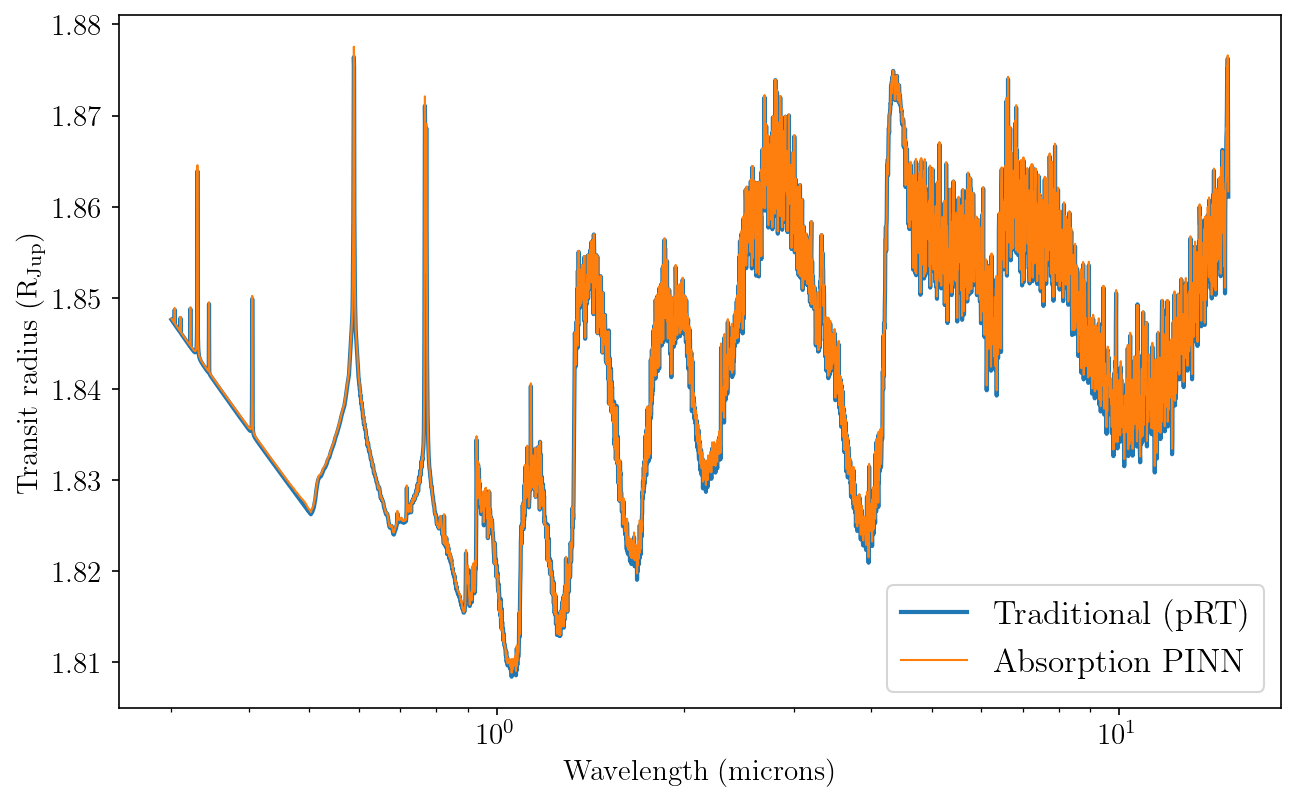

<Figure size 1500x900 with 0 Axes>

In [9]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150

plt.plot(nc.c/atmosphere.freq/1e-4, prt_transm_rad/nc.r_jup_mean, label='Traditional (pRT)', linewidth=2.0)
plt.plot(nc.c/atmosphere.freq/1e-4, pinn_transm_rad/nc.r_jup_mean, label='Absorption PINN', linewidth=1.0)
if extra_spec:
    plt.plot(nc.c/atmosphere.freq/1e-4, rayleigh_transm_rad/nc.r_jup_mean, label='Rayleigh PINN', linewidth=0.5)
    plt.plot(nc.c/atmosphere.freq/1e-4, rayleigh_abs_transm_rad/nc.r_jup_mean, label='Rayleigh PINN w/o scattering', linewidth=0.5)

plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Transit radius ($\rm R_{Jup}$)')
plt.legend()
plt.show()
plt.clf()

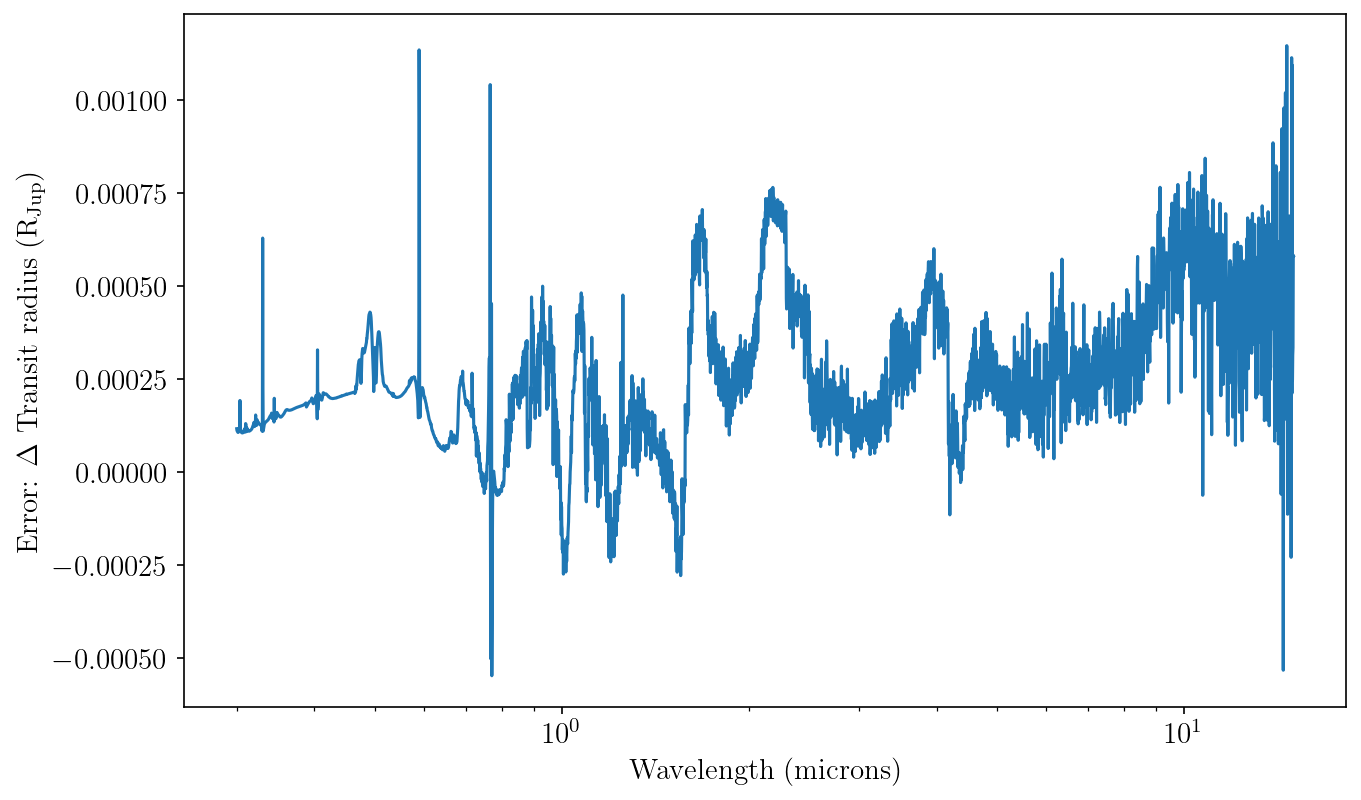

<Figure size 1500x900 with 0 Axes>

In [10]:
error = pinn_transm_rad - prt_transm_rad
max_diff = prt_transm_rad.max() - prt_transm_rad.min()

plt.plot(nc.c/atmosphere.freq/1e-4, error/nc.r_jup_mean)

if extra_spec:
    error_2 = rayleigh_transm_rad - prt_transm_rad
    error_3 = rayleigh_abs_transm_rad - prt_transm_rad
    plt.plot(nc.c/atmosphere.freq/1e-4, error_2/nc.r_jup_mean)
    plt.plot(nc.c/atmosphere.freq/1e-4, error_3/nc.r_jup_mean)


plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Error: $\Delta$ Transit radius ($\rm R_{Jup}$)')
plt.show()
plt.clf()

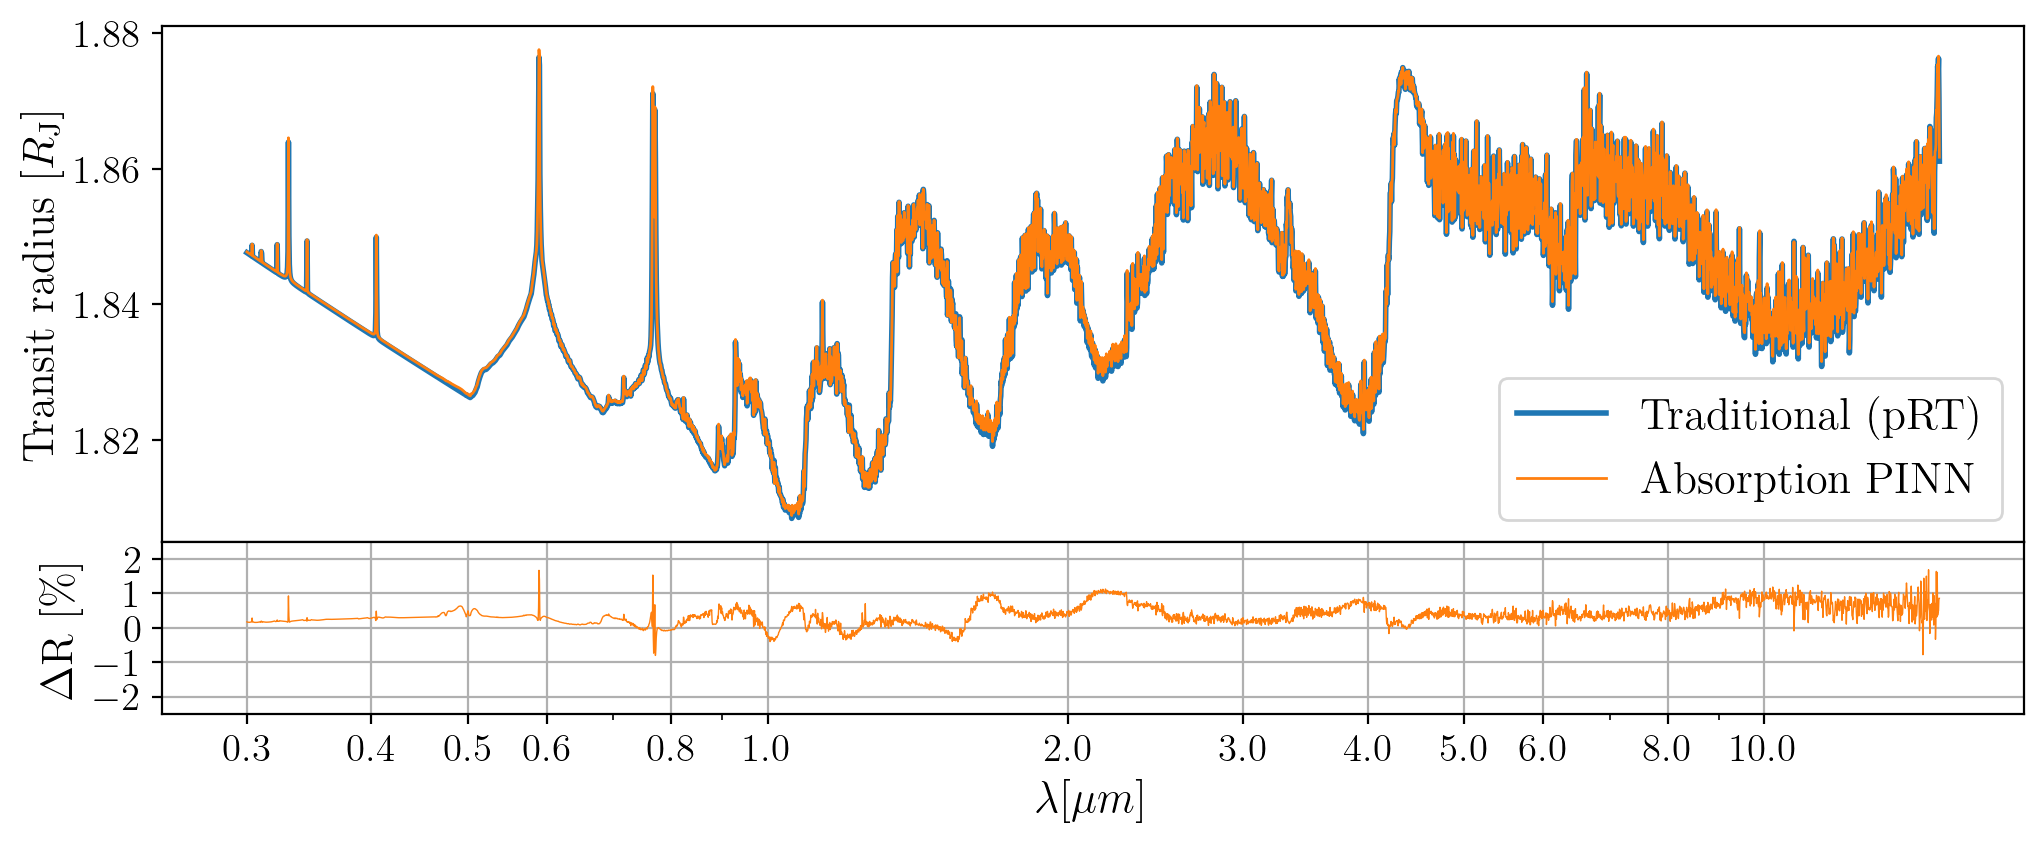

[ 938 3906 3904  675 3886]
0.47425587533486613


<Figure size 1500x900 with 0 Axes>

In [15]:
fontsize = 16

fig, ax = plt.subplots(2,1, figsize=(10.5,4.5), sharex=True, gridspec_kw={'height_ratios': [3, 1]}, dpi=200)

ax[0].plot(nc.c/atmosphere.freq/1e-4, prt_transm_rad/nc.r_jup_mean, label='Traditional (pRT)', linewidth=2.0)
ax[0].plot(nc.c/atmosphere.freq/1e-4, pinn_transm_rad/nc.r_jup_mean, label='Absorption PINN', linewidth=1.0)
if extra_spec:
    ax[0].plot(nc.c/atmosphere.freq/1e-4, rayleigh_transm_rad/nc.r_jup_mean, label='Rayleigh PINN', linewidth=0.5)
    ax[0].plot(nc.c/atmosphere.freq/1e-4, rayleigh_abs_transm_rad/nc.r_jup_mean, label='Rayleigh PINN w/o scattering', linewidth=0.5)

ax[0].set_xscale('log')
#ax[0].set_xlabel('Wavelength (microns)', fontsize=16)
ax[0].set_ylabel(r'Transit radius [$R_\mathrm{J}$]', fontsize=fontsize)
ax[0].legend()

#ax[0].hlines(atmosphere.radius_hse/nc.r_jup_mean, xmin=(nc.c/atmosphere.freq/1e-4).min(), xmax=(nc.c/atmosphere.freq/1e-4).max(),
#            color='black', linewidth=0.1)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax[1].plot(nc.c/atmosphere.freq/1e-4, error/max_diff*100, linewidth=0.5, color=default_colors[1])
if extra_spec:
    ax[1].plot(nc.c/atmosphere.freq/1e-4, error_2/max_diff*100, linewidth=0.5, color=default_colors[2])
    ax[1].plot(nc.c/atmosphere.freq/1e-4, error_3/max_diff*100, linewidth=0.5, color=default_colors[3])

ax[1].set_ylabel(r'$\Delta$R [\%]', fontsize=fontsize)
ax[1].set_ylim((-2.5, 2.5))
ax[1].set_yticks((-2,-1,0,1,2))

ax[1].set_xlabel(r'$\lambda [\mu m]$', fontsize=fontsize)
xticks = np.concatenate((np.round(np.linspace(0.3,0.9,7), decimals=1), np.round(np.linspace(1,10,10), decimals=0)))
ax[1].set_xticks(xticks)
xticks[[4,6,13,15]] = np.nan
ax[1].set_xticklabels(xticks)

plt.grid()
plt.tight_layout()
plt.subplots_adjust(hspace=.0)
#plt.savefig('../images/ExampleSpec_AbsPINN_6x64_seed=3.png', dpi=300)
plt.show()
plt.clf()

print(np.argsort(abs(error), axis=0)[-5:])

rel_error = error/max_diff*100
print(np.sqrt(np.mean(rel_error**2)))

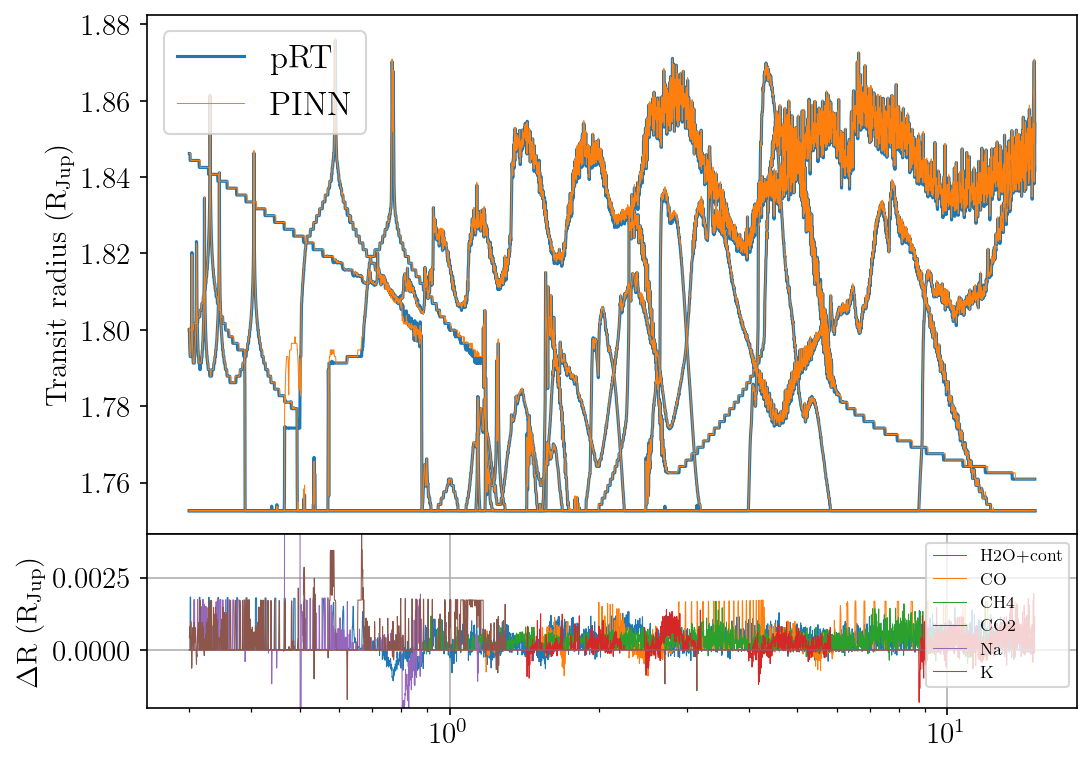

Max error indices of K :
[658 798 799 800 797]


<Figure size 1500x900 with 0 Axes>

In [17]:
prt_05transm = atmosphere.radius_hse[np.argmin(abs(prt_transm-0.5), axis=-1)]
pinn_05transm = atmosphere.radius_hse[np.argmin(abs(pinn_transm-0.5), axis=-1)]

prt_05transm[prt_transm[:,:,:,-1]>=0.99] = atmosphere.radius_hse[-1]
pinn_05transm[pinn_transm[:,:,:,-1]>=0.99] = atmosphere.radius_hse[-1]

prt_05transm = np.sum(atmosphere.w_gauss.reshape(-1,1,1) * prt_05transm, axis=0)
pinn_05transm = np.sum(atmosphere.w_gauss.reshape(-1,1,1) * pinn_05transm, axis=0)

cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=True, gridspec_kw={'height_ratios': [3, 1]}, dpi=150)

ax[0].plot(nc.c/atmosphere.freq/1e-4, prt_05transm/nc.r_jup_mean, label='pRT', c=cmap(0))
ax[0].plot(nc.c/atmosphere.freq/1e-4, pinn_05transm/nc.r_jup_mean, label='PINN', c=cmap(1), linewidth=0.5)

ax[0].set_xscale('log')
ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
handles, labels = ax[0].get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax[0].legend(newHandles, newLabels)

#ax[0].hlines(atmosphere.radius_hse/nc.r_jup_mean, xmin=(nc.c/atmosphere.freq/1e-4).min(), xmax=(nc.c/atmosphere.freq/1e-4).max(),
#            color='black', linewidth=0.1)

species_error = pinn_05transm - prt_05transm
species_label = ['H2O+cont', 'CO', 'CH4', 'CO2', 'Na', 'K']

ax[1].plot(nc.c/atmosphere.freq/1e-4, species_error[:,:]/nc.r_jup_mean, linewidth=0.5, label=species_label)
ax[1].legend(loc='upper right', fontsize=8)

ax[1].set_ylabel(r'$\Delta$R ($\rm R_{Jup}$)')
ax[1].set_ylim((-0.002, 0.004))

plt.grid()
plt.subplots_adjust(hspace=.0)
plt.show()
plt.clf()

#print(np.unravel_index(np.argmax(species_error), species_error.shape))
# print the indices with of the wavelength with the maximum error for a certain species
# (to further analyze origin of error)
i_species = 5
print('Max error indices of', species_label[i_species], ':')
print(np.argsort(abs(species_error), axis=0)[-5:,i_species]) # print indices 

797 0.665793285829066


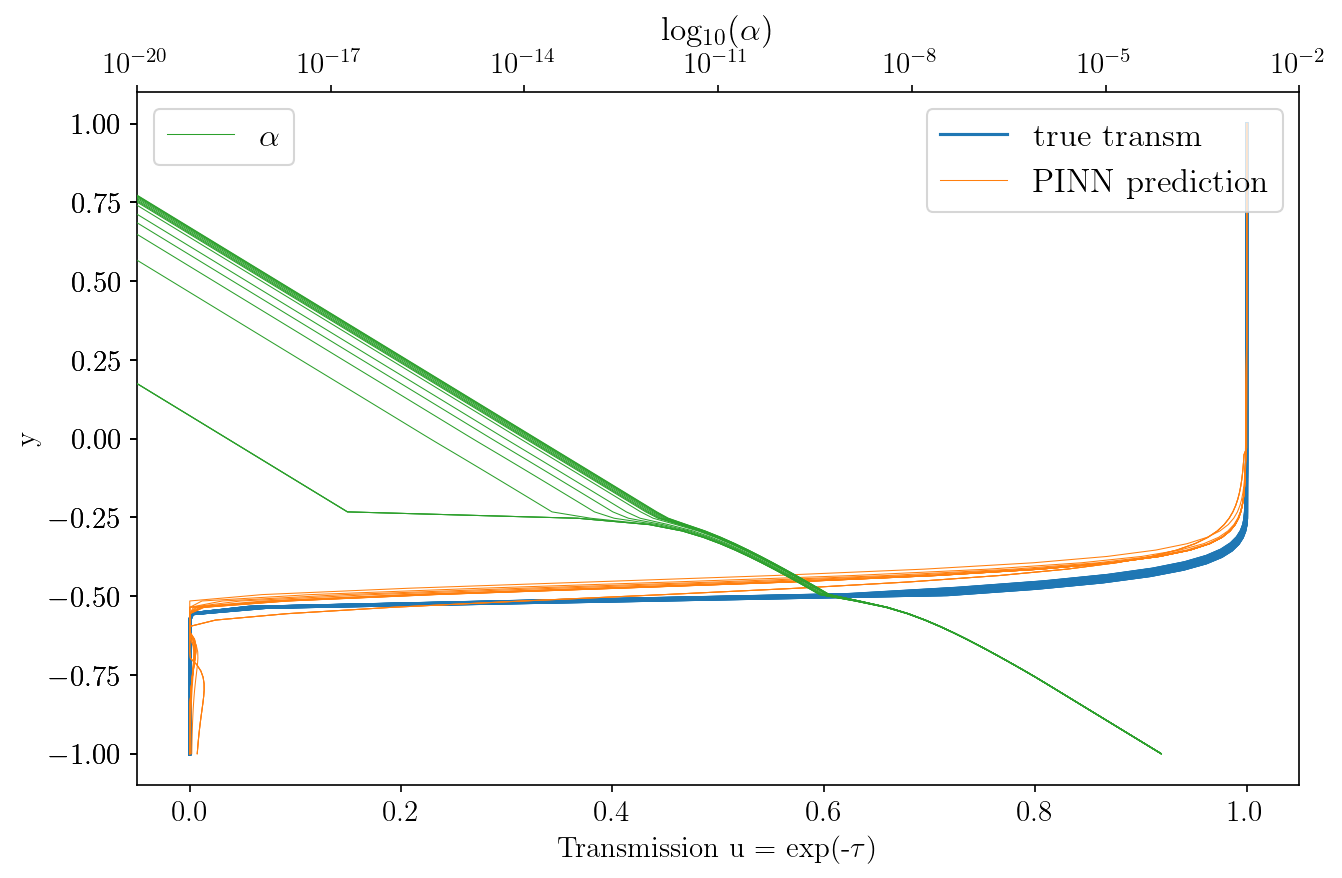

In [43]:
ind = 797
i_species = 5
print(ind, (nc.c/atmosphere.freq/1e-4)[ind])

fig=plt.figure()#dpi=300)
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

n_profiles = atmosphere.alphas[:,ind,i_species,:].reshape(-1,100).shape[0]
no_labels = ['']*(n_profiles-1)
ax2.plot(atmosphere.alphas[:,ind,i_species,:].reshape(-1,100).swapaxes(0,1), np.linspace(1,-1,100), label=no_labels+[r'$\alpha$'], c=cmap(2), linewidth=0.5)
ax.plot(prt_transm[:,ind,i_species,:].reshape(-1,100).swapaxes(0,1), np.linspace(1,-1,100), label=no_labels+['true transm'], c=cmap(0))
ax.plot(pinn_transm[:,ind,i_species,:].reshape(-1,100).swapaxes(0,1), np.linspace(1,-1,100), c=cmap(1), linewidth=0.5, label=no_labels+['PINN prediction'])

# ax.set_yscale('log')
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.xaxis.tick_top()
ax2.set_xlim(1e-20, 1e-2)
# ax.invert_yaxis()
# ax2.invert_yaxis()
ax.legend(loc='upper right')
ax2.legend(loc='upper left')

ax.set_ylabel('y')
ax.set_xlabel(r'Transmission u = exp(-$\tau$)')
#ax2.set_xlabel(r'log$_{10}(\alpha)$')
#ax2.xaxis.set_label_position('top') 
ax2.set_title(r'log$_{10}(\alpha)$')

fig.show()

3


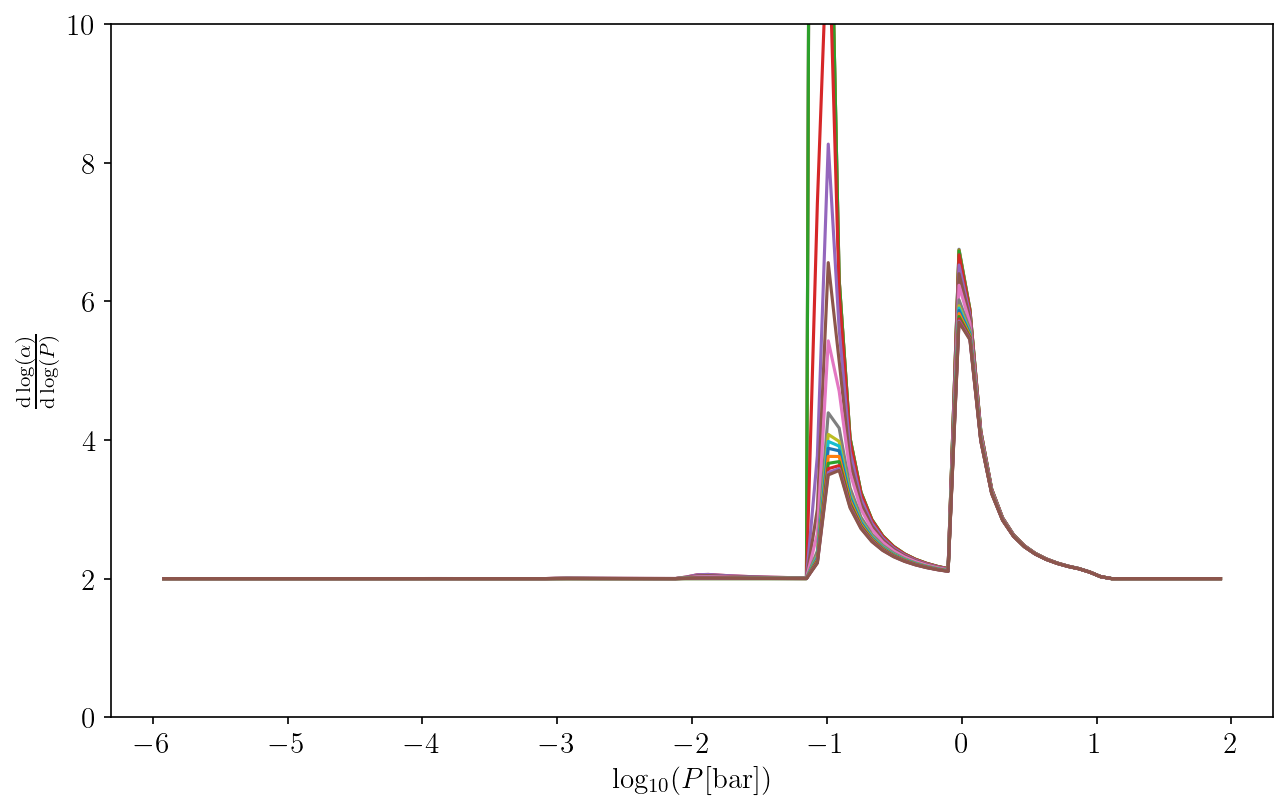

In [52]:
k_i = np.argmax(np.mean(abs(pinn_transm[:,ind,i_species,:] - prt_transm[:,ind,i_species,:])**2, axis=-1))
print(k_i)

for i in range(prt_transm[:,ind,i_species,:].shape[0]):
    # i=k_i
    log_grad_alpha = np.log10(atmosphere.alphas[i,ind,i_species,1:]) - np.log10(atmosphere.alphas[i,ind,i_species,:-1])
    # plt.plot(np.linspace(1,-1,100)[1:-1], log_grad_alpha[1:]*99/8)
    plt.plot(np.linspace(-6,2,100)[1:-1], log_grad_alpha[1:]*99/8)
    # plt.plot(np.arange(100), (np.log10(atmosphere.alphas[i,ind,i_species,:])-np.linspace(-18,-6,100))/4.5)
plt.ylim((0,10))

plt.xlabel(r'log$_{10}(P[\mathrm{bar}])$')
plt.ylabel(r'$\frac{\mathrm{d \, log}(\alpha)}{\mathrm{d \, log} (P)}$')
plt.show()

(2, 100)
(2, 99)


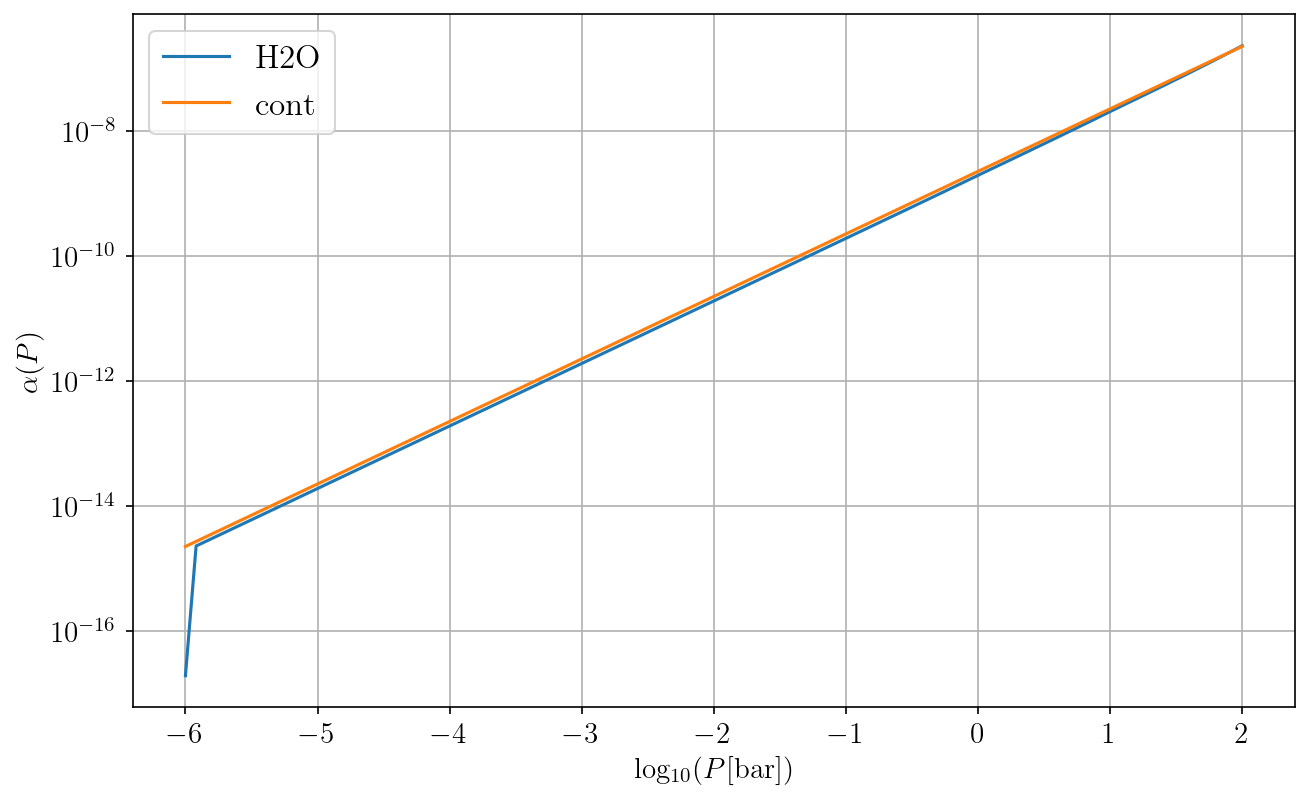

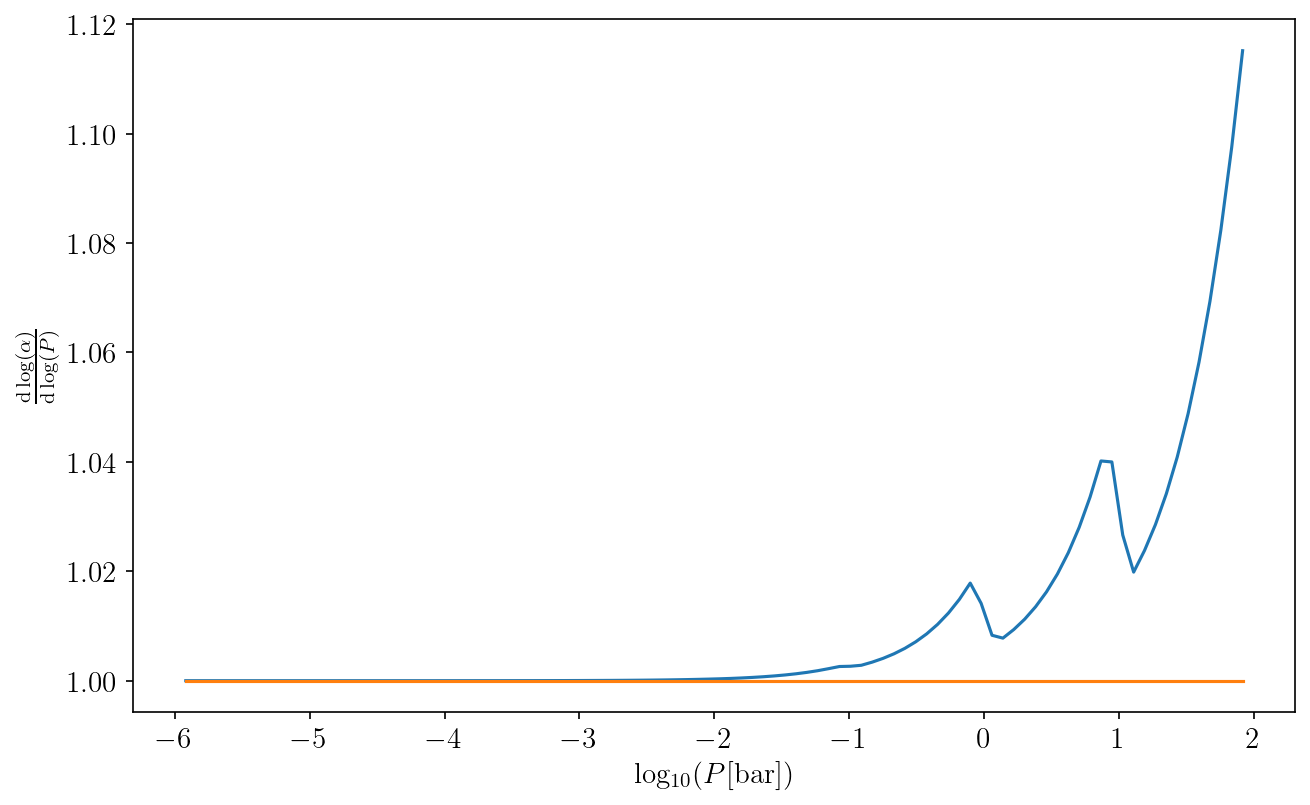

In [65]:
# split H2O and continuum

test_alpha = atmosphere.alphas[k_i,ind,0,:]

rho = atmosphere.press * MMW * 1.66053892e-24 / 1.3806488e-16 / atmosphere.temp
test_alpha = np.array([test_alpha - (atmosphere.continuum_opa_scat[ind,:]*rho), (atmosphere.continuum_opa_scat[ind,:]*rho)])
print(test_alpha.shape)
plt.plot(np.linspace(-6,2,100), test_alpha.swapaxes(0,1), label=['H2O', 'cont'])
plt.legend()
plt.yscale('log')

log_grad_alpha = np.log10(test_alpha[:,1:]) - np.log10(test_alpha[:,:-1])
print(log_grad_alpha.shape)
# plt.plot(np.linspace(1,-1,100)[1:-1], log_grad_alpha[:,1:].swapaxes(0,1)*99/8)
plt.xlabel(r'log$_{10}(P[\mathrm{bar}])$')
plt.ylabel(r'$\alpha(P)$')
plt.grid()
plt.show()

plt.plot(np.linspace(-6,2,100)[1:-1], log_grad_alpha[:,1:].swapaxes(0,1)*99/8)
plt.xlabel(r'log$_{10}(P[\mathrm{bar}])$')
plt.ylabel(r'$\frac{\mathrm{d \, log}(\alpha)}{\mathrm{d \, log} (P)}$')
plt.show()

7.8316595102350375
0.0007236480530414247


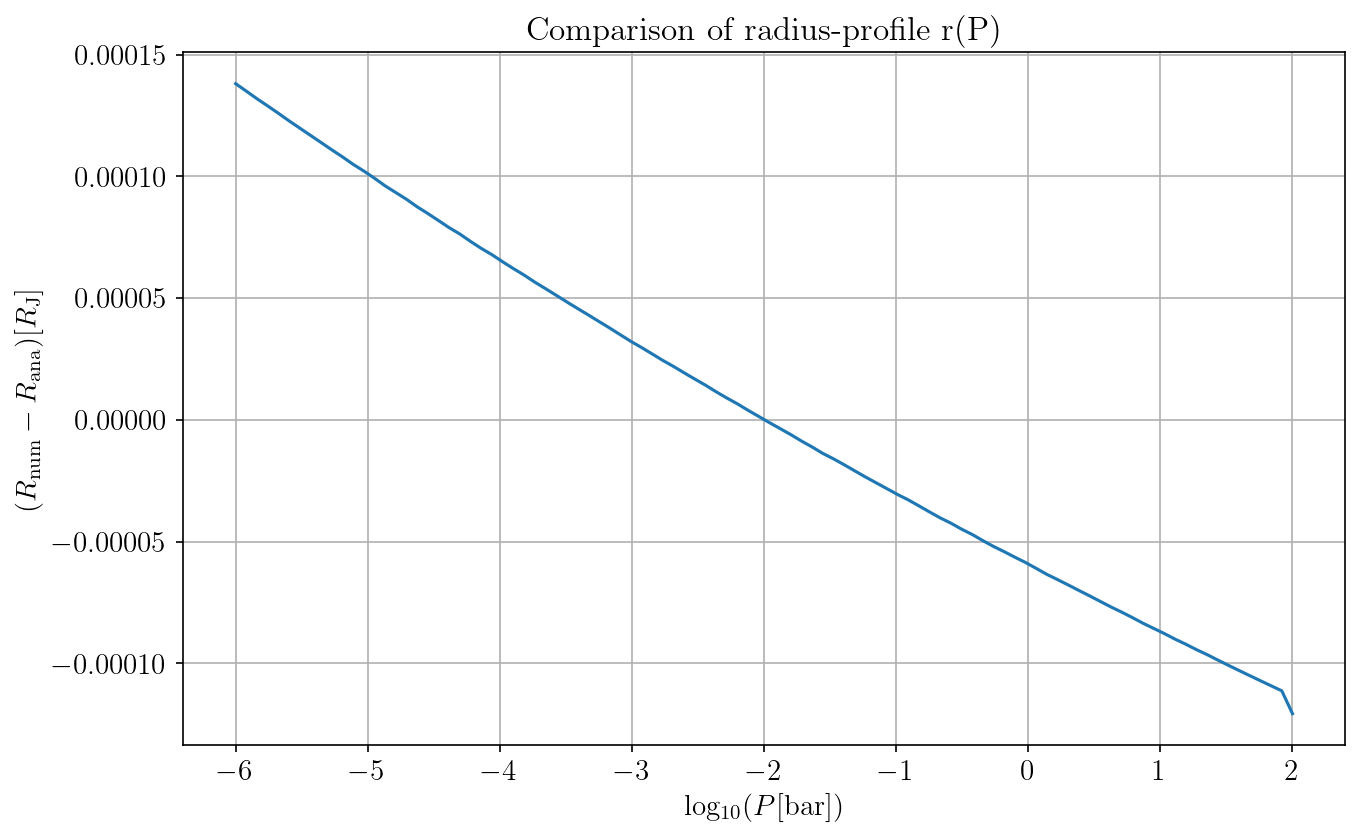

In [89]:
ind_atm = False

# Compare calculation of radius profile r(P)
# numerical integration by pRT vs. analytical solution (with T=const, MMW=const and variable gravity) used for PINN

r = atmosphere.radius_hse
# r = (r - r.min()) / (r.max()-r.min())*2 - 1
if ind_atm != False:
    MMW = calc_MMW(atm_params.iloc[ind_atm])
    a = (nc.kB * atm_params.iloc[ind_atm,0]) / (10**atm_params.iloc[ind_atm,-1]*1e2*MMW[0]*nc.amu)
    r_analytical = atmosphere.r_isotherm(a, atm_params.iloc[ind_atm,5]*nc.r_jup_mean).cpu().numpy()
else:
    a = (nc.kB * temperature[0]) / (gravity*MMW[0]*nc.amu)
    r_analytical = atmosphere.r_isotherm(a, R_pl).cpu().numpy()
print(np.log10(a))
plt.plot(np.linspace(-6,2,100), r/nc.r_jup_mean-r_analytical/nc.r_jup_mean);
#plt.plot(np.linspace(-6,2,100), r/nc.r_jup_mean);
#plt.plot(np.linspace(-6,2,100), r_analytical/nc.r_jup_mean);
plt.grid()

plt.xlabel(r'log$_{10}(P[\mathrm{bar}])$')
plt.ylabel(r'$(R_\mathrm{num}-R_\mathrm{ana}) [R_\mathrm{J}]$')
plt.title('Comparison of radius-profile r(P)')

r_factor = np.sqrt(r[0]**2 - r[-1]**2)
r_ana_factor = np.sqrt(r_analytical[0]**2 - r_analytical[-1]**2)
print((r_factor - r_ana_factor)/r_factor)


ind    = 3886
lambda = 14.617566079390452 um
R      = 1.8632014463954825 R_J


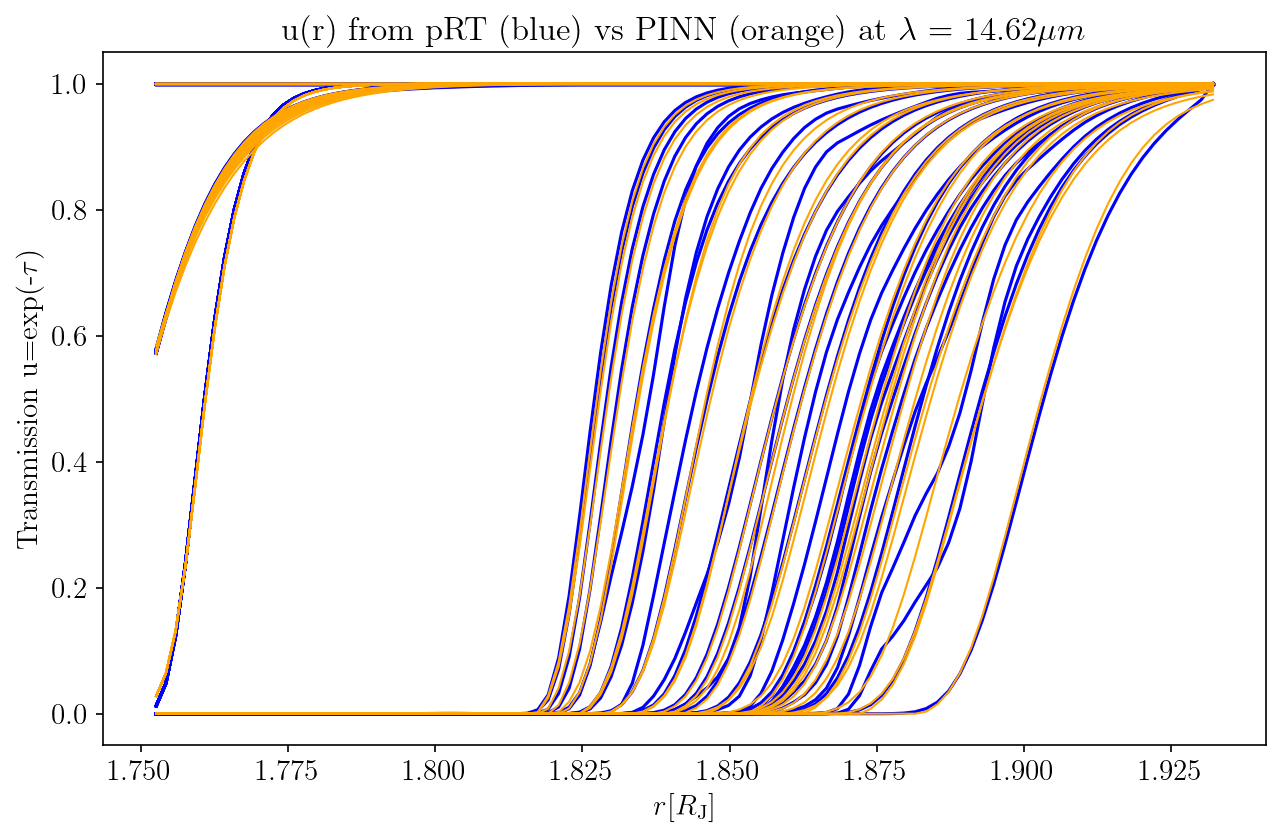

In [102]:
# plot all transmission-profiles u(r) at certain wavelength (with max. error)
# pRT (blue) vs PINN (orange)

max_error_i = np.argmax(np.abs(error))
print('ind    =', max_error_i)
print('lambda =', (nc.c/atmosphere.freq/1e-4)[max_error_i], 'um')
print('R      =', (prt_transm_rad/nc.r_jup_mean)[max_error_i], 'R_J')
x = atmosphere.radius_hse/nc.r_jup_mean
plt.plot(x,prt_transm[:,max_error_i,:,:].reshape(-1,100).swapaxes(0,1), c='blue');
plt.plot(x,pinn_transm[:,max_error_i,:,:].reshape(-1,100).swapaxes(0,1), c='orange', linewidth=1.0);

plt.xlabel(r'$r [R_\mathrm{J}]$')
plt.ylabel(r'Transmission u=exp(-$\tau$)')
plt.title(r'u(r) from pRT (blue) vs PINN (orange) at $\lambda$ = ' + f'{(nc.c/atmosphere.freq/1e-4)[max_error_i]:.2f}' + r'$\mu m$')
plt.show()